# 네이버 검색어 트랜드 (Open API)
- 우리가 하려는 것이 'https://datalab.naver.com/'에서 '검색어 트렌드'에서 하는 것을 내부적으로 (코딩으로) 하는 것이다.
## 1. 작업 준비
### 1) 패키지 참조

In [1]:
import requests
import json
from pandas import DataFrame, to_datetime

import sys
sys.path.append("../../")
from helper import set_datetime_index, exp_time_data

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

## 2. 네이버 검색어 트렌드 OpenAPI 연동
### 1) 접속에 필요한 정보 설정
#### API url
- 'https://developers.naver.com/docs/serviceapi/datalab/search/search.md#%ED%86%B5%ED%95%A9-%EA%B2%80%EC%83%89%EC%96%B4-%ED%8A%B8%EB%A0%8C%EB%93%9C' 에 있음
    - '통합 검색어 트렌드 API 레퍼런스' -> '요청 URL' 

In [2]:
API_URL = 'https://openapi.naver.com/v1/datalab/search'

#### 발급받은 인증키
- 'https://developers.naver.com/apps/#/list'에 있음
    - 'application' -> '내 애플리케이션'
    - 내 거 개인
    - 하루 1000건 까지만 허용

In [3]:
client_id = 'E7zZdiJ9OvbDWhXGJLZB'
client_secret = 'vlizPe9VVf'

### 2) 접속 객체 생성

In [4]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

### 3) HTTP 접속 방법 종류

#### a. HTTP GET 방식인 경우

```python
session.get(API_URL, params={"a":100, "b":200})
```

#### b. HTTP POST 방식인 경우

```python
session.post(API_URL, data={"a":100, "b":200})
```

#### c. HTTP POST 방식이면서 파라미터를 JSON으로 구성하는 경우(body data 전송)

```python
session.post(API_URL, data=json.dumps({"a":100, "b":200}))
```
> 우리가 사용할 방식

### 4) 전달할 검색어 구성
- startDate과 endDate는 내가 원하는 날짜로 설정

In [8]:
data = {
    "startDate": "2020-01-01",      # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "date",             # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {"groupName": "코로나",       # 검색 주제
        "keywords": ["코로나", "Covid19", "격리", "확진자"]     # 주제와 관련된 검색어
        }
    ]
}

### 5) 데이터 요청하기

In [9]:
# 생성한 접속객체를 활용하여 API에 접속
r = session.post(API_URL, data = json.dumps(data))

# 접속에 실패한 경우
if r.status_code != 200:
    # 에러코드와 에러메시지 출력
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    # 에러를 강제로 생성시킴
    raise Exception(msg)

# 인코딩 형식 지정
r.encoding = "utf-8"
# 가져온 문자열을 json.loads() 함수로 r.text (위에 접속한 api의 text형태) 를 딕셔너리로 변환
mydict = json.loads(r.text)
mydict

{'startDate': '2020-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': '코로나',
   'keywords': ['코로나', 'Covid19', '격리', '확진자'],
   'data': [{'period': '2020-01-01', 'ratio': 0.00869},
    {'period': '2020-01-02', 'ratio': 0.01115},
    {'period': '2020-01-03', 'ratio': 0.01228},
    {'period': '2020-01-04', 'ratio': 0.01182},
    {'period': '2020-01-05', 'ratio': 0.0096},
    {'period': '2020-01-06', 'ratio': 0.01228},
    {'period': '2020-01-07', 'ratio': 0.01192},
    {'period': '2020-01-08', 'ratio': 0.0118},
    {'period': '2020-01-09', 'ratio': 0.05425},
    {'period': '2020-01-10', 'ratio': 0.04167},
    {'period': '2020-01-11', 'ratio': 0.01865},
    {'period': '2020-01-12', 'ratio': 0.01171},
    {'period': '2020-01-13', 'ratio': 0.01305},
    {'period': '2020-01-14', 'ratio': 0.01334},
    {'period': '2020-01-15', 'ratio': 0.01238},
    {'period': '2020-01-16', 'ratio': 0.01632},
    {'period': '2020-01-17', 'ratio': 0.01752},
    {'period': '2020-01-1

### 6) 가져온 결과를 데이터프레임으로 변환

In [10]:
df = DataFrame(mydict['results'][0]['data'])
df

,period,ratio
0,2020-01-01,0.00869
1,2020-01-02,0.01115
2,2020-01-03,0.01228
3,2020-01-04,0.01182
4,2020-01-05,0.00960
...,...,...
1303,2023-07-27,1.11399
1304,2023-07-28,0.91158
1305,2023-07-29,0.65329
1306,2023-07-30,0.79660


## 3. 연동 결과에 대한 시계열 분석
### 1) 데이터 타입 확인

In [11]:
df.dtypes # -> 외부에서 갖고 온 날짜 데이터는 거의 무조건 문자열이다.

period     object
ratio     float64
dtype: object

### 2) 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [12]:
df['period'] = to_datetime(df['period'])
# set_date_index()는 helper.py 모듈에 있는 함수
df2 = set_datetime_index(df, 'period') 
df2

,ratio
2020-01-01,0.00869
2020-01-02,0.01115
2020-01-03,0.01228
2020-01-04,0.01182
2020-01-05,0.00960
...,...
2023-07-27,1.11399
2023-07-28,0.91158
2023-07-29,0.65329
2023-07-30,0.79660


### 3) helper에 구현된 기능 활용하여 데이터 검정
- 만약 exp_time_data()함수의 파라미터 중 sd_model="m"으로 할 때 에러가 나면 데이터 값에 0으로 된 것이 있기 때문이다.
    - 이 땐 "a"로 해줘야 됨

결측치 수: 0


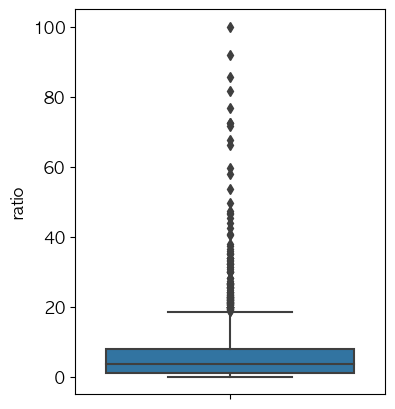

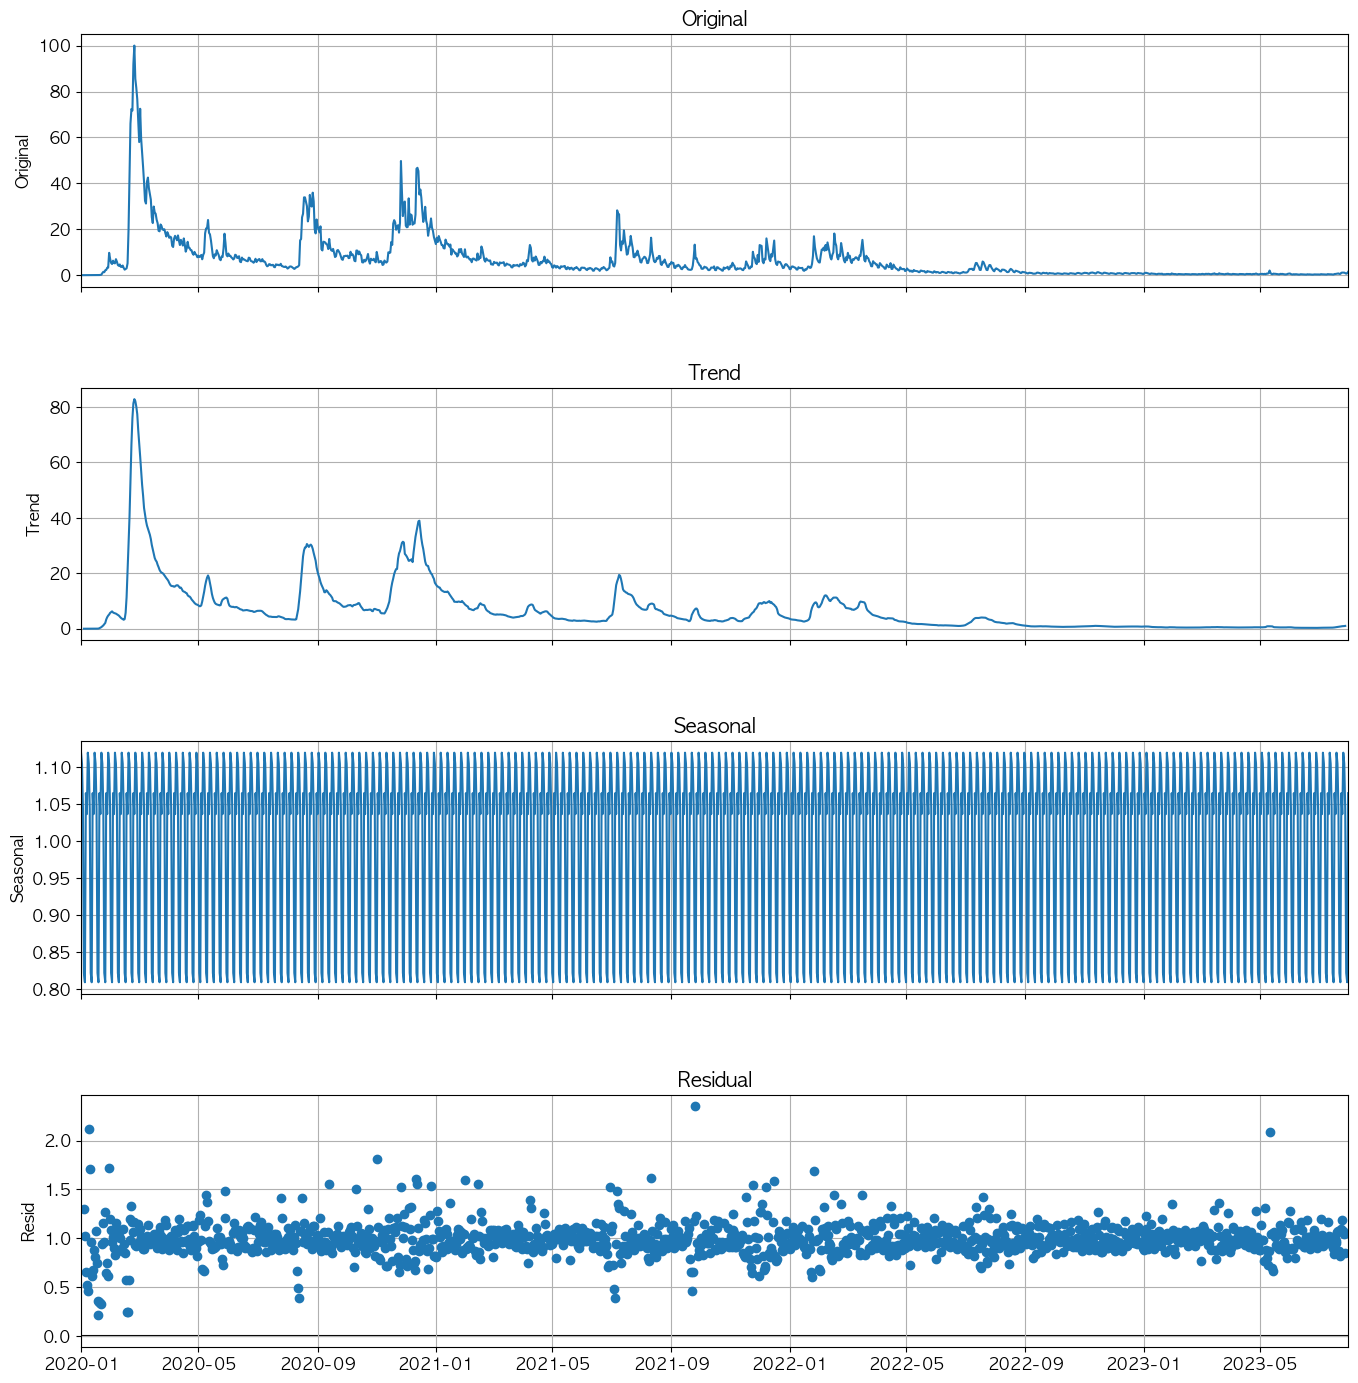

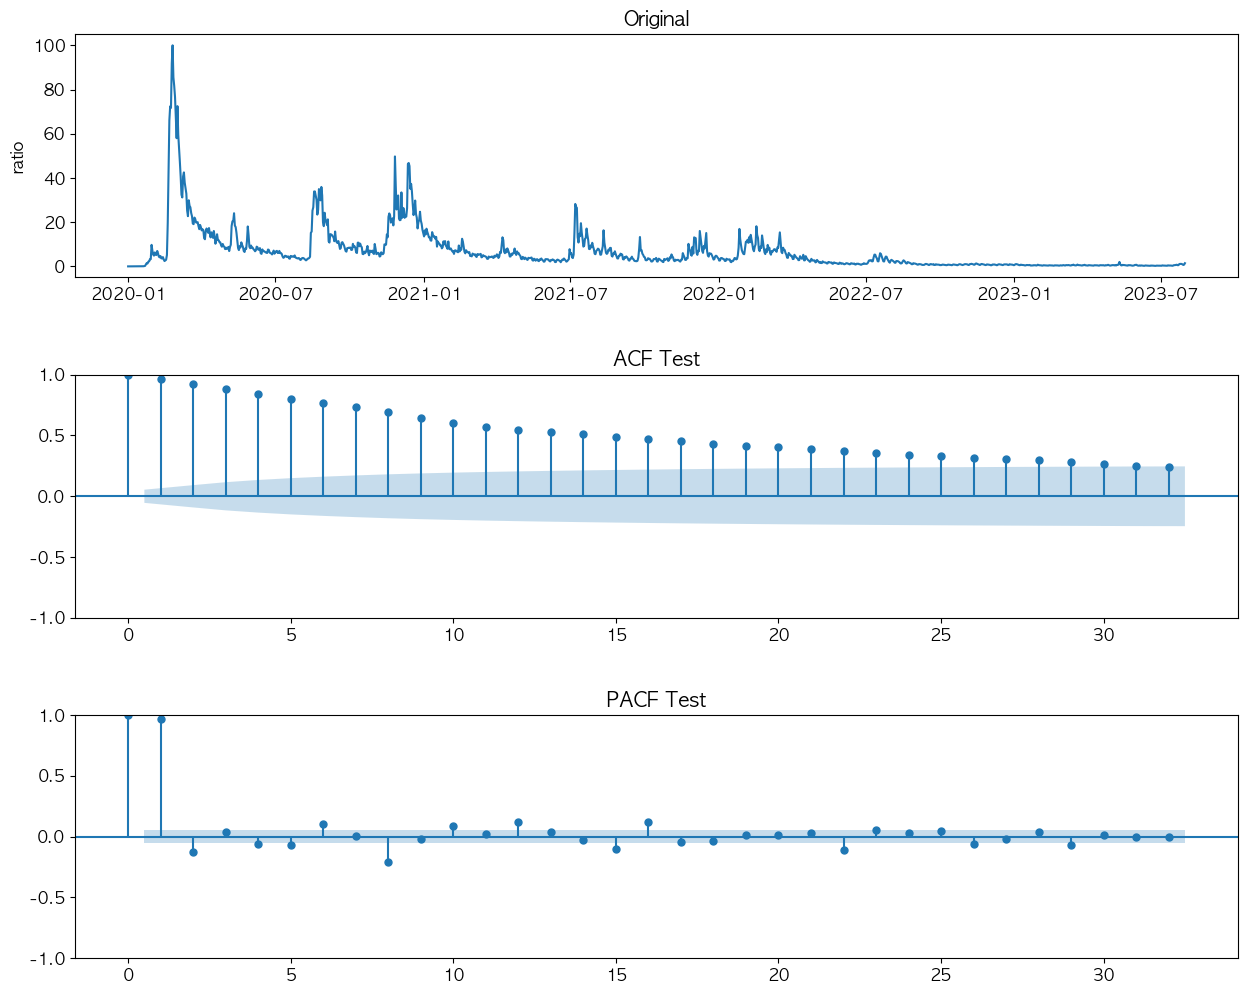

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.34384 |
| 유의수준(p-value)                  | 0.000372653 |
| 최적차수(num of lags)              |          22 |
| 관측치 개수(num of observations)   |        1285 |
| 기각값(Critical Values) 1%         |    -3.43545 |
| 기각값(Critical Values) 5%         |    -2.86379 |
| 기각값(Critical Values) 10%        |    -2.56797 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [13]:
exp_time_data(df2, 'ratio', 'm')

> Original 표: 점점 감소하고 있고, 이 표를 분석한 결과 곱하기 방식("m")이 맞는 것이로 보임
> ACF Test가 PACF Test보다 더 완만한 것으로 보임 -> AR(1)모델로 결정

### 4) ARIMA 분석 수행
#### 분석 모델 구성

In [14]:
model = ARIMA(df2['ratio'], 
              order=(1, 0, 0), 
              seasonal_order=(1, 1, 0, 7))
my_fit = model.fit()
print(my_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           ratio   No. Observations:                 1308
Model:             ARIMA(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood               -3248.578
Date:                         Tue, 08 Aug 2023   AIC                           6503.155
Time:                                 12:05:18   BIC                           6518.668
Sample:                             01-01-2020   HQIC                          6508.975
                                  - 07-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9257      0.003    321.180      0.000       0.920       0.931
ar.S.L7       -0.4509      0.009    -51.925      0.000     

#### 학습 결과에 대한 예측값 확인

In [15]:
fv = my_fit.fittedvalues
fv.head()

2020-01-01    0.000000e+00
2020-01-02    3.340554e-07
2020-01-03    7.150223e-07
2020-01-04    1.080002e-06
2020-01-05    1.363607e-06
Freq: D, dtype: float64

#### 향후 30일 간의 예상치 생성

In [16]:
fc = my_fit.forecast(30)
fc.head()

2023-08-01    1.451125
2023-08-02    1.436420
2023-08-03    1.435407
2023-08-04    1.312900
2023-08-05    1.036610
Freq: D, Name: predicted_mean, dtype: float64

#### 시각화

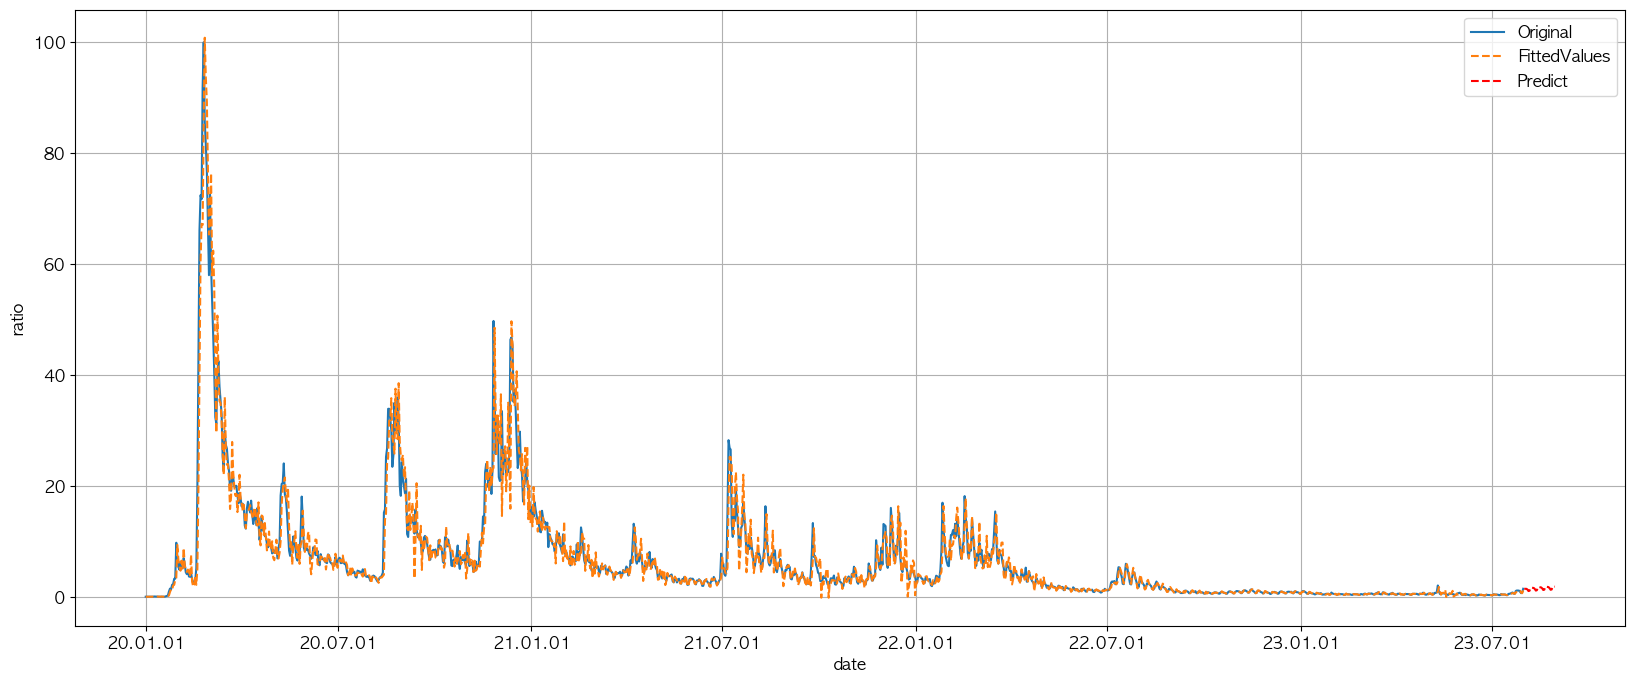

In [17]:
plt.figure(figsize=(20,8))

sb.lineplot(data=df2, x=df2.index, y='ratio', label='Original')
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

### 5) AutoARIMA 분석 수행
- 결과값이 비슷할 것이라서 생략